In [22]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
from scipy import constants 
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from matplotlib.ticker import LogLocator

from scipy.special import jn  # Bessel function of the first kind
from scipy.integrate import quad  # For numerical integration
from matplotlib.lines import Line2D

# ------- Set paramters for figures ---------
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['legend.frameon'] = False

In [23]:
## This function and the next function is not used in the code but could be useful for furutre purpose
def luminosity_distance(z):
    """Calculate the luminosity distance D_L for a given redshift z, assuming a flat ΛCDM cosmology."""
    
    pc = constants.parsec # Parsec (m)
    c = constants.c # Speed of light (m/s)

    # Flat ΛCDM Universe
    H0 = 67.4 * 1e3 / (1e6 * pc)  # Hubble constant in m/s/Mpc
    Omega_m = 0.315  # Matter density parameter
    Omega_Lambda = 0.685  # Dark energy density parameter

    # Function to integrate for comoving distance
    def integrand(z_prime):
        return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_Lambda)
    
    # Integrate from 0 to z to get the comoving distance
    integral, _ = quad(integrand, 0, z)
    
    # Calculate luminosity distance
    D_L = (1 + z) * (c / H0) * integral
    return D_L

def bessel_sum(n, e):
    """Calculate the sum inside the g(n, e) formula using Bessel functions."""
    term1 = jn(n - 2, n * e) - 2 * e * jn(n - 1, n * e)
    term1 += (2 / n) * jn(n, n * e) + 2 * e * jn(n + 1, n * e) - jn(n + 2, n * e)
    
    term2 = (1 - e**2) * (jn(n - 2, n * e) - 2 * jn(n, n * e) + jn(n + 2, n * e))
    
    term3 = (4 / (3 * n**2)) * jn(n, n * e)**2
    
    return term1**2 + term2**2 + term3

def g(n, e):
    """Calculate g(n, e) for the nth harmonic."""
    return (n**4 / 32) * bessel_sum(n, e)

def h_n(n, M_chirp, e, f, z=None, D_L=None):
    """
    Calculate the gravitational wave strain h_n for the nth harmonic, with two options for the distance:
    1. If D_L is supplied, use it directly.
    2. If D_L is not supplied, calculate it using the redshift z.
    
    Parameters:
    n       : Harmonic number
    M_chirp : Chirp mass in kg
    e       : Orbital eccentricity
    f       : Orbital frequency in Hz
    z       : Redshift of the source (only used if D_L is not supplied)
    D_L     : Luminosity distance in meters (optional; if provided, it overrides z)
    """

    G = constants.G # Gravitational constant (m^3/kg/s^2)
    Msun = 1.989e30  # Solar mass (kg)
    c = constants.c # Speed of light (m/s)

    # Use the supplied D_L if provided, otherwise calculate it from redshift z
    if D_L is None:
        if z is None:
            raise ValueError("Either redshift (z) or luminosity distance (D_L) must be provided.")
        # Calculate D_L using the redshift
        D_L = luminosity_distance(z)
    
    # Calculate the strain amplitude for the nth harmonic
    ecc_fac = 1 - (5/2)*e**2 + (35/24)*e**4
    strain = (8 * G**(5/3) * M_chirp**(5/3) * np.pi**(2/3) * f**(2/3)) / (5**0.5 * D_L * c**4) * ecc_fac
    
    # g(n, e) is the eccentricity-dependent term
    return strain 

In [24]:
# Testing the above 

# Constants (in SI units)
G = constants.G # Gravitational constant (m^3/kg/s^2)
Msun = 1.989e30  # Solar mass (kg)
c = constants.c # Speed of light (m/s)
pc = constants.parsec # Parsec (m)
yr = constants.year  # seconds in yr

# Parameters
M_chirp = 1.2 * Msun  # Chirp mass in kg
z = 0.5               # Redshift of the source
D_L_supplied = None   # Set this to None if you want to calculate D_L from z
e = 0.                # Eccentricity of the orbit
f = 1e-3              # Orbital frequency in Hz
n = 2                 # Harmonic number (e.g., second harmonic)

# Option 1: If you know D_L (in meters), pass it directly
D_L_supplied =  8.1*1e3*pc

# Option 2: If you don't know D_L, let the function compute it from redshift z
if D_L_supplied is None:
    h = h_n(n, M_chirp, e, f, z=z)
else:
    h = h_n(n, M_chirp, e, f, D_L=D_L_supplied)

print(f"Gravitational wave strain h_{n} = {h:.3e}")

Gravitational wave strain h_2 = 1.779e-22


In [25]:
def calc_SNR(T_obs, f, m1, m2, e, z, D_L=None):
    """ Calculating SNR for the galactic (and extra galactic) sources """ 
 
    # Define parameter values
    G = constants.G # Gravitational constant (m^3/kg/s^2)
    Msun = 1.989e30  # Solar mass (kg)
    c = constants.c # Speed of light (m/s)
    pc = constants.parsec # Parsec (m)
    yr = constants.year  # seconds in yr
    
    # Fix the parameters of the confusion noise fit. This bit has been copied from Robson and Cornish 2018
    if (T_obs == 0.5):
        est = 1
    elif (T_obs == 1.0):
        est = 2
    elif (T_obs == 2.0):
        est = 3
    elif (T_obs == 4.0):
        est = 4

    # else find the closest observation period estimation
    else:
        if (T_obs < .75):
            est = 1
        elif (0.75 < T_obs and T_obs < 1.5):
            est = 2
        elif (1.5 < T_obs and T_obs < 3.0):   
            est = 3
        else:
            est = 4
            
    if (est==1):
        alpha  = 0.133
        beta   = 243.
        kappa  = 482.
        gamma  = 917.
        fk = 2.58e-3  
    elif (est==2):
        alpha  = 0.171
        beta   = 292.
        kappa  = 1020.
        gamma  = 1680.
        fk = 2.15e-3 
    elif (est==3):
        alpha  = 0.165
        beta   = 299.
        kappa  = 611.
        gamma  = 1340.
        fk = 1.73e-3  
    else:
        alpha  = 0.138
        beta   = -221.
        kappa  = 521.
        gamma  = 1680.
        fk = 1.13e-3 

    # Define the expressions for P_OMS and P_acc
    P_OMS = (1.5e-11)**2 * (1 + (2e-3 / f)**4)
    P_acc = (3e-15)**2 * (1 + (0.4e-3 / f)**2) * (1 + (f / 8e-3)**4)
    T_obs = T_obs * yr
    
    A = 9e-45 # amplitude below
    L = 2.5 * 1e9  # Value for L
    f_star = 19.09 * 1e-3  

    # Define the expression for S_c
    S_WDB = A * f**(-7/3) * np.exp(-f**alpha + beta * f * np.sin(kappa * f)) * (1 + np.tanh(gamma * (fk - f)))
    S_ins = (10 / (3 * L**2)) * (P_OMS + (4 * P_acc) / (2 * np.pi * f)**4) * (1 + (6 / 10) * (f / f_star)**2)
    S_n =  S_ins + S_WDB
   
    if D_L != None:
        D_L = D_L * pc # Distance between LISA and the galactic center (converting to parsec) 
        
    m1   = m1 * Msun
    m2   = m2 * Msun
    Mtot = m1 + m2
    mu   = m1 * m2 / Mtot
    M_chirp = mu**(3/5)*Mtot**(2/5)
    n = 2
    hn = h_n(n, M_chirp, e, f, z, D_L)
        
    SNR = hn * T_obs**(0.5) / S_n**0.5
    
    return SNR 

In [26]:
# Testing the above
# T = np.linspace(2,10, 100)
calc_SNR(3.5, 1e-3, 3, 29, 0., 0., 8e3)  #calc_SNR(T_obs, f, m1, m2, e, d) # supply in units of yr, Hz, Msun, Msun, kpc

132.87903155386516

In [27]:
def velocity_c_Bulge(r):
    """
    Calculate the circular velocity for a given radius (r) in pc using the galactic Bulge
    """

    G = constants.G  # Gravitational constant in m^3 kg^-1 s^-2
    M_bulge = 1.067e10  # Mass of the bulge in M_sun
    M_sun = 1.989e30
    r_b = 0.3e3  # Scale radius in parsecs
    pc = constants.parsec

    # Converting r to meters
    r_b = r_b * pc
    r = r * pc

    # Converting M_bulge to kg
    M_bulge = M_bulge * M_sun
    v_c = np.sqrt((G * M_bulge * r**2) / (r**2 + r_b**2)**(3/2))
    
    return v_c

def velocity_c_NFW(r):
    """
    Calculate the circular velocity  for a given radius (r) in pc using the NFW profile.
    """

    pc = constants.parsec # (m)
    G = constants.G # Gravitational constant in m^3 kg^-1 s^-2
    M_sun = 1.989e30

    r = r * pc
    rho_0 = 0.052 * M_sun / (pc)**3  # Characteristic density in SI units for MW. Values taken from arxiv 1906.08419
    r_s = 8.1*1e3 * pc     # Scale radius in kpc
    
    term1 = r_s / (r_s + r)
    term2 = np.log( (r_s + r) / r_s)
    v_c = np.sqrt(4 * np.pi * G * rho_0 * (r_s**3 / r) * (term1 + term2 - 1))
    return v_c


In [28]:
# Testing the above 
distance = 10 # [pc] from galactic center
print(f"circular velocity at {distance} pc for MW Bulge    = {velocity_c_Bulge(distance) / 1e3:.2f} [km/s]")
print(f"circular velocity at {distance} pc for MW NFW halo = {velocity_c_NFW(distance) /1e3:.2f} [km/s]")

circular velocity at 10 pc for MW Bulge    = 13.03 [km/s]
circular velocity at 10 pc for MW NFW halo = 10.66 [km/s]


In [35]:
def Mchirp_evo(T_obs, f_in, th, m10, m20, e0, r_center):
    """ Calculate the evolution of chirp mass as the black holes accrete mass """
    
    # Define parameter values
    G = constants.G  # Gravitational constant (m^3/kg/s^2)
    Msun = 1.989e30  # Solar mass (kg)
    c = constants.c  # Speed of light (m/s)
    pc = constants.parsec  # Parsec (m)
    yr = constants.year  # seconds in yr
    k_B = constants.k  # Boltzmann const
    lambda_ = 1.12  # example constant
    gamma = 1  # 4.99/3

    theta = th
    m10 = m10 * Msun
    m20 = m20 * Msun
    T_obs = T_obs * yr

    f0 = f_in
    r0 = (G * (m10 + m20) / (4 * np.pi**2 * (f0 / 2)**2))**(1 / 3)  # Kepler's third law for initial separation

    v_inf = velocity_c_NFW(r_center) # 10_000  # velocity in m/s

    rho_0 = 0.052 * Msun / (pc)**3
    # r_center = 1  # location of binary in parsecs
    r_earth = 8.1 * 1e3  # LISA's location in parsecs
    rho_inf = rho_0 / (r_center / r_earth) / (1 + r_center / r_earth)**2
    cs = np.sqrt(gamma * theta * c**2)

    # Define the differential equations
    def dm1_dt(t, m_1):
        """ Calculate dm1/dt separately """
        return (4 * np.pi * lambda_ * G**2 * m_1**2 * rho_inf) / ((cs**2 + v_inf**2)**(3 / 2))

    def dm2_dt(t, m_2):
        """ Calculate dm2/dt separately """
        return (4 * np.pi * lambda_ * G**2 * m_2**2 * rho_inf) / ((cs**2 + v_inf**2)**(3 / 2))

    def d_mu_dt(t, m_1, m_2):
        mu = m_1 * m_2 / (m_1 + m_2)
        return (4 * np.pi * lambda_ * G**2 * mu**2 * rho_inf) / ((cs**2 + v_inf**2)**(3 / 2))

    def dr_dt_GW(t, r, m_1, m_2, e):
        mu = m_1 * m_2 / (m_1 + m_2)
        M = m_1 + m_2
        return - (64 / 5) * (G**3 * mu * M**2) / (c**5 * r**3 * (1 - e**2)**3.5) * (1 + 73 * e**2 / 24 + 37 * e**4 / 96)

    def dr_dt_AM(t, r, m_1, m_2, e):
        mu = m_1 * m_2 / (m_1 + m_2)
        M = m_1 + m_2

        dot_m1 = dm1_dt(t, m_1)
        dot_m2 = dm2_dt(t, m_2)
        dot_mu = d_mu_dt(t, m_1, m_2)

        # Compute the time derivative of ln(mu^2 M)
        d_ln_mu2M_dt = (2 * dot_mu / mu) + ((dot_m1 + dot_m2) / M)

        # Compute the rate of change of r with respect to time
        return -r * (d_ln_mu2M_dt - 2 * e / (1 - e**2) * de_dt_AM(t, m_1, m_2, e))

    def de_dt_GW(r, m_1, m_2, e):
        mu = m_1 * m_2 / (m_1 + m_2)
        M = m_1 + m_2
        term = G**3 * mu * M**2 / (c**5 * r**4 * (1 - e**2)**(5 / 2))
        return - (304 / 15) * e * term * (1 + (121 / 304) * e**2)

    def de_dt_AM(t, m_1, m_2, e):
        M = m_1 + m_2
        dot_m1 = dm1_dt(t, m_1)
        dot_m2 = dm2_dt(t, m_2)
        return -e * (dot_m1 + dot_m2) / M

    def df_dt(t, f, m_1, m_2, r, e):
        dot_m1 = dm1_dt(t, m_1)
        dot_m2 = dm2_dt(t, m_2)
        dot_r = dr_dt_GW(t, r, m_1, m_2, e) + dr_dt_AM(t, r, m_1, m_2, e)
        M = m_1 + m_2
        return (G**(1 / 2) / (2 * np.pi)) * r**(-3 / 2) * M**(-1 / 2) * ((dot_m1 + dot_m2) - (3 * M / r) * dot_r)

    # Function to integrate the system of equations
    def system_of_eqs(t, y):
        m_1, m_2, r, f, e = y
        if r <= 0:
            return [0, 0, 0, 0, 0]

        dot_m1 = dm1_dt(t, m_1)
        dot_m2 = dm2_dt(t, m_2)
        dot_r = dr_dt_GW(t, r, m_1, m_2, e) + dr_dt_AM(t, r, m_1, m_2, e)

        if e > 0:
            dot_e = de_dt_GW(r, m_1, m_2, e) + de_dt_AM(t, m_1, m_2, e)
        else:
            dot_e = 0

        dot_f = df_dt(t, f, m_1, m_2, r, e)
        return [dot_m1, dot_m2, dot_r, dot_f, dot_e]

    # Time span for integration
    t_upper = (T_obs + 1 * yr)
    t_span = (0, t_upper)  # integrate from t=0 to t_upper
    y0 = [m10, m20, r0, f0, e0]  # initial conditions

    # Solve the system of differential equations
    solution = solve_ivp(system_of_eqs, t_span, y0, method='RK45', t_eval=np.linspace(0, t_upper, 1000))

    # Extract the solutions
    t_values = solution.t
    m1_values = solution.y[0]
    m2_values = solution.y[1]
    r_values = solution.y[2]
    f_values = solution.y[3]
    e_values = solution.y[4]

    # Calculate df/dt at a specific time t
    index = np.abs(t_values - T_obs).argmin()  # find the index closest to T_obs

    M_target = m1_values[index] + m2_values[index]
    r_target = r_values[index]
    f_target = f_values[index]
    e_target = e_values[index]
    df_dT_obs = df_dt(T_obs, f_target, m1_values[index], m2_values[index], r_target, e_target)

    mu_target = (m1_values[index] * m2_values[index]) / (m1_values[index] + m2_values[index])
    Mchirp = (mu_target)**(3 / 5) * (M_target)**(2 / 5)
    
    df_dt_val = df_dT_obs

    return [Mchirp / Msun, df_dt_val, r_target, f_target, e_target]

In [30]:
def sigma_Mchirp(SNR, T_obs, Mchirp, df_dt_val):
    """ Calculate uncertainty in chirp mass measurement """

    yr = constants.year  # seconds in yr
    T_obs = T_obs * yr
    
    sigma_Mchirp = 0.258 * (SNR / 10)**(-1) * T_obs**(-2) * Mchirp / df_dt_val
    
    return sigma_Mchirp

In [31]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
linestyles = ['-', '--', ':']

## Figure 1 in the paper

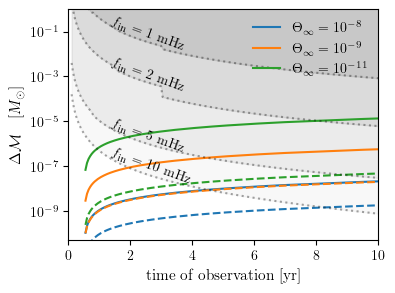

In [32]:
plt.figure(figsize=(4, 3))  
T = np.linspace(1e-1,10, 200)
yr = constants.year 
theta = [1e-8, 1e-9, 1e-11]  # DM dimensionless temperature

# fixed the first measurement time to t_1 = 0.5 yr
f_in = 1e-3 # This f_in value if dummy. Changing it won't change result.
i = 0
m1 = 25
m2 = 25
e = 0.
t_1 = 0.5
D_L = 8.1 * 1e3 # pc 
z = 0
r_center = [1, 10] # in parsecs, the location of the black hole binary from the center of the host galaxy

# ---------- for plotting the curves ------------
k = 0
for r_c in r_center:
    i = 0
    for th in theta:
        del_Mch = []
        time = []
        for T_obs in T:
            if T_obs > t_1:
                delta_Mch = Mchirp_evo(T_obs, f_in, th, m1, m2, e, r_c)[0]  - Mchirp_evo(t_1, f_in, th, m1, m2, e, r_c)[0]  # Mchirp_evo returns [Mchirp/Msun, df_dt_val, r_target, f_target, e_target]
                
                if del_Mch[-1] >= delta_Mch:
                    break                
                else:
                    del_Mch.append(delta_Mch)
                    time.append(T_obs)
            else:
                del_Mch.append(0)
                time.append(T_obs)

        mask = np.array(time)>0.5
        plt.plot(np.array(time)[mask],np.array(del_Mch)[mask], color = colors[i], linestyle = linestyles[k])
        i +=1
    k += 1
   

# # ------ for plotting the shaded area ------------
r_c = 10 # using the largest value for calculating the region of detectability
f = [1e-2, 5e-3, 2e-3, 1e-3]
j = 0
alp = [0.05, 0.1, 0.15, 0.2]
for f_in in f:
    sig_Mchirp = []
    for i in range(len(T)):
        if i == 0:

            Mchirp = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[0]
            df_dt_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[1]
            f_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[3]
            SNR = calc_SNR(T[i], f_val, m1, m2, e, z, D_L)
    #         print(SNR)

            sig_Mchirp_val = sigma_Mchirp(SNR, T[i], Mchirp, df_dt_val)
    #         print(sig_Mchirp_val)
            sig_Mchirp.append(sig_Mchirp_val)
        else: 
            Mchirp = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[0]
            e = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[4]
            df_dt_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[1]
            f_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[3]
            SNR = calc_SNR(T[i], f_val, m1, m2, e, z, D_L)
    #         print(SNR)

            sig_Mchirp_val = sigma_Mchirp(SNR, T[i], Mchirp, df_dt_val)
    #         print(sig_Mchirp_val)
            sig_Mchirp.append(sig_Mchirp_val)

    # y_1 = np.full_like(T, sig_Mchirp[np.where(T == t_1)[0][0]])
    # plt.plot(T, y_1 + sig_Mchirp, linestyle = ':', color = 'k', alpha = 0.35)
    # plt.fill_between(T, y_1 + sig_Mchirp, 10., alpha = alp[j], color = 'gray')
    # plt.text(T[20], 2.5 * sig_Mchirp[20], rf'$f_{{\rm in}}$ = {f_in * 1e3:.0f} mHz', rotation=-10)

    plt.plot(T, 2 * np.array(sig_Mchirp), linestyle=':', color='k', alpha=0.35)
    plt.fill_between(T, 2 * np.array(sig_Mchirp), 10., alpha=alp[j], color='gray')
    plt.text(T[25], sig_Mchirp[52], rf'$f_{{\rm in}}$ = {f_in * 1e3:.0f} mHz', rotation=-20)
    j+=1


plt.xlabel('time of observation [yr]', fontsize = 11)
plt.ylabel(r'$\Delta \mathcal{M} \quad [M_\odot]$', fontsize = 11)

# plt.text(3.5, 2e-11,'Detectable region (LISA)')
plt.xlim(0,10)
plt.ylim(5e-11, 1)
plt.locator_params(axis='x', nbins=6)
plt.yscale('log') 
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))

labels = [r"$\Theta_\infty = 10^{-8}$", r'$\Theta_\infty = 10^{-9}$', r'$\Theta_\infty = 10^{-11}$']

# Create separate legends for theta and r_center
legend_r_center = [rf"$r_{{\rm center}} = {r_c}$ pc" for r_c in r_center]

from matplotlib.lines import Line2D
# Define custom line objects (solid and dashed, both black)
solid_line = Line2D([0], [0], color='black', lw=2, linestyle='-')  # Solid line
dashed_line = Line2D([0], [0], color='black', lw=2, linestyle='--')  # Dashed line
line_styles = [solid_line, dashed_line]

# Add legend for r_center with custom line styles
r_center_legend = plt.legend(line_styles, legend_r_center, loc='upper center', frameon=False, bbox_to_anchor=(0.51, 1.2), ncol = 2)
plt.gca().add_artist(r_center_legend)
plt.legend(labels, loc='upper right', frameon=False)

# plt.savefig('galactic_point_particle_DM_detectability.pdf',bbox_inches='tight')
plt.show()

In [33]:
def gw_merger_time(m1_solar_masses, m2_solar_masses, f, e):
    """
    Calculate the merger time for an eccentric binary system using the fitting formula from Ilya Mandel 2021.

    Parameters:
    m1_solar_masses: Mass of the first black hole in solar masses.
    m2_solar_masses: Mass of the second black hole in solar masses.
    f (float): Initial orbital frequency of the binary system in Hz.
    e (float): Initial eccentricity of the binary system.

    Returns:
    Merger time in years.
    """
    # Constants
    Msun = 1.989 * 1e30  # Solar mass in kg
    G = constants.G  # Gravitational constant
    c = constants.c  # Speed of light
    yr = constants.year
    
    # Convert masses from solar masses to kg
    m1 = m1_solar_masses * Msun
    m2 = m2_solar_masses * Msun

    # Compute the initial semi-major axis using Kepler's third law (for initial circular orbit approximation)
    a0 = (G * (m1 + m2) / (4 * np.pi**2 * (f / 2)**2))**(1 / 3)

    # Calculate beta
    beta = (64 / 5) * (G**3 * m1 * m2 * (m1 + m2)) / (c**5)

    # Calculate merger time for circular binary (Tc)
    Tc_circular = (a0**4) / (4 * beta)

    # Apply the fitting formula for eccentric binaries
    eccentric_factor = (1 + 0.27 * e**10 + 0.33 * e**20 + 0.2 * e**1000) * (1 - e**2)**(7 / 2)
    Tc_eccentric = Tc_circular * eccentric_factor

    # Convert merger time from seconds to years
    Tc_years_eccentric = Tc_eccentric / yr

    return Tc_years_eccentric

# # test usage:
m1 = 36  # Mass of first black hole in solar masses
m2 = 29  # Mass of second black hole in solar masses
f = 1e-2  # Initial orbital frequency in Hz
e = 0.5  # Initial eccentricity

merger_time = gw_merger_time(m1, m2, f, e)
print(f"merger time = {merger_time:.2e} years.")


merger time = 6.22e+00 years.


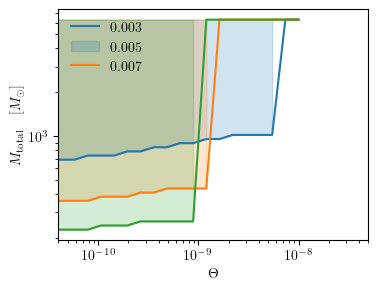

In [34]:
# -------  Sample case for figure 3 in paper (test case for faster output, can be ignored) -------

plt.figure(figsize=(4, 3)) 
M_arr = np.logspace(1, 3.8, 100) # BBH mass
theta = np.logspace(-10.5, -8., 20) # Dark matter dimensionless temperature

f_in = [3e-3, 5e-3, 7e-3]
D_L = 5e7
z = 0.
e = 0.
t_1 = 4
T_obs = t_1 + 0.1
rc = 1 # pc

i=0
for f in f_in:
    Min_M_for_th = []
    for th in theta:
        Flag = 0
        for M in M_arr:
            m1 = M/2
            m2 = M/2
            t_merge = gw_merger_time(m1, m2, f, e)
            # t_merge = 11
        
            if t_merge > T_obs:
                delta_Mch = Mchirp_evo(T_obs, f, th, m1, m2, e, rc)[0]  - Mchirp_evo(t_1, f, th, m1, m2, e, rc)[0] # Mchirp_evo returns [Mchirp/Msun, df_dt_val, r_target, f_target, e_target]
                df_dt_val = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[1]
                f_val = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[3]
                Mchirp = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[0]
                
                SNR = calc_SNR(t_1, f_val, m1, m2, e, z, D_L)
                sig_Mchirp_val = sigma_Mchirp(SNR, t_1, Mchirp, df_dt_val)

                if delta_Mch >= 2 * sig_Mchirp_val:
                    Min_M_for_th.append(M)
                    Flag = 1
                    # print('y')
                    break 
            # else:
            #     print('merges early', rf'{m1:.2f}', m2, rf'{th:.2e}')

        if Flag == 0:
            Min_M_for_th.append(np.max(M_arr))

    plt.plot(theta, Min_M_for_th, color = colors[i])
    plt.fill_between(theta, Min_M_for_th, y2=max(M_arr), where=(Min_M_for_th < max(M_arr)), \
                                            alpha=0.2, color = colors[i],label = '$f = 1$ mHz')
    i+=1

plt.xlim(4e-11, 5e-8)
plt.yscale('log') 
plt.xscale('log')
plt.xlabel(r'$\Theta$')
plt.ylabel(r'$M_{\rm total} \quad [M_\odot]$')
plt.legend(f_in)
plt.show()


## Figure 3 in the paper

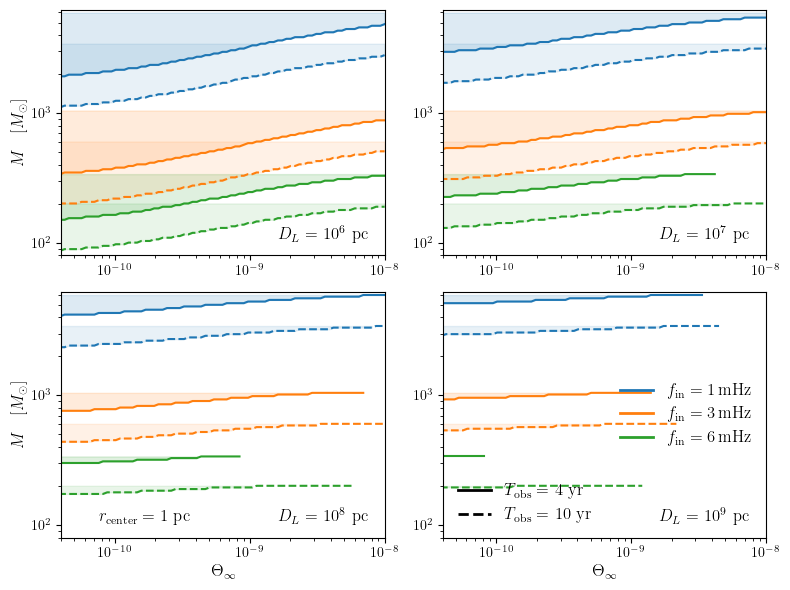

In [37]:
# Set up parameters
M_arr = np.logspace(1.8, 3.8, 160)
theta = np.logspace(-10.5, -8., 80)
f_in = [1e-3, 3e-3, 6e-3]
D_L_values = [1e6, 1e7, 1e8, 1e9]  # D_L values for subplots
D_L_latex = [r'$10^6$', r'$10^7$', r'$10^8$', r'$10^9$']  # LaTeX formatting for D_L
t_1_values = [3.9, 9.9]  # In years
z = 0
e = 0
T_obs_offset = 0.1
rc = 1  # pc
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Define colors for the different f_in values
line_styles = ['-', '--']  # Solid and dashed lines for the two t_1 values

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()  

# Iterate over D_L values and create subplots
for idx, D_L in enumerate(D_L_values):
    ax = axes[idx]
    
    for t_idx, t_1 in enumerate(t_1_values):
        T_obs = t_1 + T_obs_offset
        i = 0
        
        for f in f_in:
            Min_M_for_th = []  # Minimum M values for plotting
            Max_M_for_th = []  # Maximum M values for fill area
            valid_th = []  # Corresponding \Theta values
            
            for th in theta:
                Flag = 0
                min_M = None  # Store first valid M
                max_M = None  # Store upper bound for fill

                for M in M_arr:
                    m1 = M / 2
                    m2 = M / 2
                    t_merge = gw_merger_time(m1, m2, f, e)

                    if t_merge > T_obs:
                        delta_Mch = Mchirp_evo(T_obs, f, th, m1, m2, e, rc)[0] - Mchirp_evo(t_1, f, th, m1, m2, e, rc)[0]
                        df_dt_val = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[1]
                        f_val = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[3]
                        Mchirp = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[0]
                        
                        SNR = calc_SNR(t_1, f_val, m1, m2, e, z, D_L)
                        sig_Mchirp_val = sigma_Mchirp(SNR, t_1, Mchirp, df_dt_val)

                        # Store minimum M only when the condition is first met
                        if delta_Mch >= 2 * sig_Mchirp_val and Flag == 0:
                            min_M = M  # Store first valid M
                            Flag = 1

                        # Continue collecting max_M while t_merge > T_obs
                        if Flag == 1:
                            max_M = M  # Store upper bound for fill
                    else:
                        # Stop collecting once t_merge <= T_obs
                        break

                # Store results if a valid M was found
                if min_M is not None and max_M is not None:
                    Min_M_for_th.append(min_M)
                    Max_M_for_th.append(max_M)
                    valid_th.append(th)

            # Plot only if we have valid points
            if Min_M_for_th:
                # Convert to numpy arrays for consistency
                valid_th = np.array(valid_th)
                Min_M_for_th = np.array(Min_M_for_th)
                Max_M_for_th = np.array(Max_M_for_th)

                # Set alpha values based on t_obs (t_idx: 0 for 4 years, 1 for 10 years)
                alpha_value = 0.15 if t_idx == 0 else 0.1

                # Plot the minimum M values
                ax.plot(valid_th, Min_M_for_th, color=colors[i], linestyle=line_styles[t_idx])

                # Fill the area between Min_M and Max_M
                ax.fill_between(valid_th, Min_M_for_th, Max_M_for_th, 
                                where=(Min_M_for_th < Max_M_for_th), 
                                alpha=alpha_value, color=colors[i])

            i += 1
    
    # Customize each subplot
    ax.set_ylim(80, )
    ax.set_xlim(4e-11, 1e-8)
    ax.set_xscale('log')
    ax.set_yscale('log')

    if idx == 2:
        ax.text(0.4, 0.05, r'$r_{\rm center} = 1$ pc', horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=12)
    if idx > 1:
        ax.set_xlabel(r'$\Theta_\infty$', fontsize = 12)
    if idx == 0 or idx == 2:
        ax.set_ylabel(r'$M \quad [M_\odot]$', fontsize = 12)
    
    # Add the distance in scientific notation at the lower right-hand side of each plot
    ax.text(0.95, 0.05, f'$D_L$ = {D_L_latex[idx]} pc', 
            horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=12)

# Add legends only to the first subplot (axes[0])
# Custom legend for the colors representing different frequencies (in LaTeX scientific notation)
f_in_latex = [r'$f_{\rm in} = 1 \, \mathrm{mHz}$', r'$f_{\rm in} = 3 \, \mathrm{mHz}$', r'$f_{\rm in} = 6 \, \mathrm{mHz}$']
frequency_legend_elements = [Line2D([0], [0], color=colors[i], lw=2, label=f_in_latex[i]) for i in range(len(f_in))]
legend1 = axes[3].legend(handles=frequency_legend_elements, loc='center right', frameon=False, fontsize = 12)

# Custom legend for line styles representing t_1 values
line_style_legend_elements = [Line2D([0], [0], color='black', linestyle=line_styles[i], lw=2, label=r'$T_{\rm obs}$' + f' = {T_obs} yr') for i, T_obs in enumerate([4, 10])]
legend2 = axes[3].legend(handles=line_style_legend_elements, loc='lower left', frameon=False, fontsize = 12)

# Add the first legend back using ax.add_artist so it doesn't get replaced
axes[3].add_artist(legend1)

plt.tight_layout()
plt.savefig('extagalactic_particle_field_DM_detectability.pdf', bbox_inches='tight')
plt.show()

## Figure 7 in paper (mass ratio = 0.1)

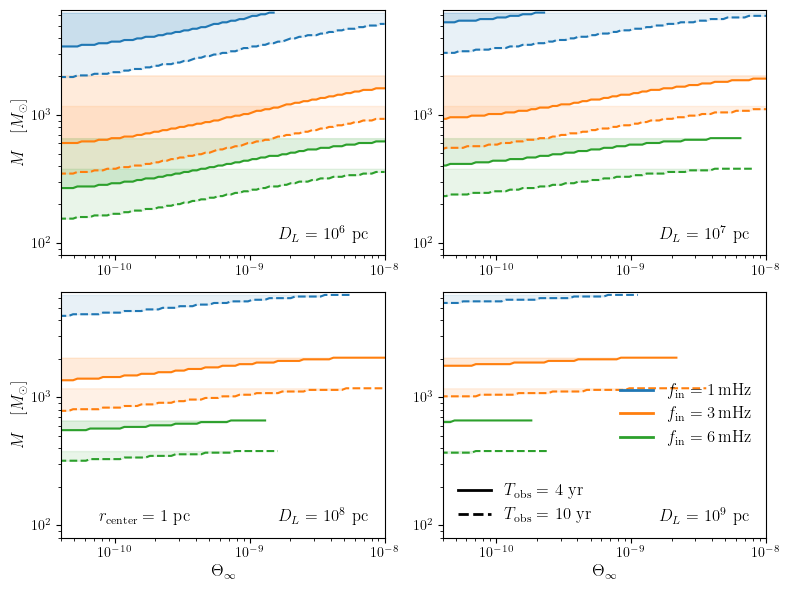

In [38]:
M_arr = np.logspace(1.8, 3.8, 160)
theta = np.logspace(-10.5, -8., 80)
f_in = [1e-3, 3e-3, 6e-3]
D_L_values = [1e6, 1e7, 1e8, 1e9]  # D_L values for subplots
D_L_latex = [r'$10^6$', r'$10^7$', r'$10^8$', r'$10^9$']  # LaTeX formatting for D_L
t_1_values = [3.9, 9.9]  # In years
z = 0
e = 0
T_obs_offset = 0.1
rc = 1  # pc
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Define colors for the different f_in values
line_styles = ['-', '--']  # Solid and dashed lines for the two t_1 values

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()  # Flatten to easily iterate over

# Iterate over D_L values and create subplots
for idx, D_L in enumerate(D_L_values):
    ax = axes[idx]
    
    for t_idx, t_1 in enumerate(t_1_values):
        T_obs = t_1 + T_obs_offset
        i = 0
        
        for f in f_in:
            Min_M_for_th = []  # Minimum M values for plotting
            Max_M_for_th = []  # Maximum M values for fill area
            valid_th = []  # Corresponding m_DM values
            
            for th in theta:
                Flag = 0
                min_M = None  # Store first valid M
                max_M = None  # Store upper bound for fill

                for M in M_arr:
                    m1 = M * 10/11
                    m2 = M - m1
                    t_merge = gw_merger_time(m1, m2, f, e)

                    if t_merge > T_obs:
                        delta_Mch = Mchirp_evo(T_obs, f, th, m1, m2, e, rc)[0] - Mchirp_evo(t_1, f, th, m1, m2, e, rc)[0]
                        df_dt_val = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[1]
                        f_val = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[3]
                        Mchirp = Mchirp_evo(t_1, f, th, m1, m2, e, rc)[0]
                        
                        SNR = calc_SNR(t_1, f_val, m1, m2, e, z, D_L)
                        sig_Mchirp_val = sigma_Mchirp(SNR, t_1, Mchirp, df_dt_val)

                        # Store minimum M only when the condition is first met
                        if delta_Mch >= 2 * sig_Mchirp_val and Flag == 0:
                            min_M = M  # Store first valid M
                            Flag = 1

                        # Continue collecting max_M while t_merge > T_obs
                        if Flag == 1:
                            max_M = M  # Store upper bound for fill
                    else:
                        # Stop collecting once t_merge <= T_obs
                        break

                # Store results if a valid M was found
                if min_M is not None and max_M is not None:
                    Min_M_for_th.append(min_M)
                    Max_M_for_th.append(max_M)
                    valid_th.append(th)

            # Plot only if we have valid points
            if Min_M_for_th:
                # Convert to numpy arrays for consistency
                valid_th = np.array(valid_th)
                Min_M_for_th = np.array(Min_M_for_th)
                Max_M_for_th = np.array(Max_M_for_th)

                # Set alpha values based on t_obs (t_idx: 0 for 4 years, 1 for 10 years)
                alpha_value = 0.15 if t_idx == 0 else 0.1

                # Plot the minimum M values
                ax.plot(valid_th, Min_M_for_th, color=colors[i], linestyle=line_styles[t_idx])

                # Fill the area between Min_M and Max_M
                ax.fill_between(valid_th, Min_M_for_th, Max_M_for_th, 
                                where=(Min_M_for_th < Max_M_for_th), 
                                alpha=alpha_value, color=colors[i])

            i += 1
    
    # Customize each subplot
    ax.set_ylim(80, )
    ax.set_xlim(4e-11, 1e-8)
    ax.set_xscale('log')
    ax.set_yscale('log')

    if idx == 2:
        ax.text(0.4, 0.05, r'$r_{\rm center} = 1$ pc', horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=12)
    if idx > 1:
        ax.set_xlabel(r'$\Theta_\infty$', fontsize = 12)
    if idx == 0 or idx == 2:
        ax.set_ylabel(r'$M \quad [M_\odot]$', fontsize = 12)
    
    # Add the distance in scientific notation at the lower right-hand side of each plot
    ax.text(0.95, 0.05, f'$D_L$ = {D_L_latex[idx]} pc', 
            horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=12)

# Add legends only to the first subplot (axes[0])
# Custom legend for the colors representing different frequencies (in LaTeX scientific notation)
f_in_latex = [r'$f_{\rm in} = 1 \, \mathrm{mHz}$', r'$f_{\rm in} = 3 \, \mathrm{mHz}$', r'$f_{\rm in} = 6 \, \mathrm{mHz}$']
frequency_legend_elements = [Line2D([0], [0], color=colors[i], lw=2, label=f_in_latex[i]) for i in range(len(f_in))]
legend1 = axes[3].legend(handles=frequency_legend_elements, loc='center right', frameon=False, fontsize = 12)

# Custom legend for line styles representing t_1 values
line_style_legend_elements = [Line2D([0], [0], color='black', linestyle=line_styles[i], lw=2, label=r'$T_{\rm obs}$' + f' = {T_obs} yr') for i, T_obs in enumerate([4, 10])]
legend2 = axes[3].legend(handles=line_style_legend_elements, loc='lower left', frameon=False, fontsize = 12)

# Add the first legend back using ax.add_artist so it doesn't get replaced
axes[3].add_artist(legend1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('extagalactic_particle_field_DM_detectability_q_pt1.pdf', bbox_inches='tight')
plt.show()

## Figure 6 in paper (particle like dark matter case, mass-ratio = 0.1)

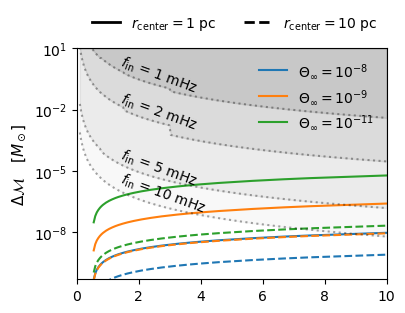

In [51]:
plt.figure(figsize=(4, 3)) 
T = np.linspace(1e-1,10, 200)
yr = constants.year 
theta = [1e-8, 1e-9, 1e-11]  # DM dimensionless temperature

# fixed the first measurement time to t_i = 0.5 yr
f_in = 1e-3 # This f_in value if dummy. Changing it won't change result.
i = 0
m1 = 500/11 # Take total mass to be 50 Msun and mass ratio = 0.1
m2 = 50 - m1
e = 0.
t_1 = 0.5
D_L = 8.1 * 1e3 # pc 
z = 0
r_center = [1, 10] # in parsecs, the location of the black hole binary from the center of the host galaxy

# ---------- for plotting the curves ------------
k = 0
for r_c in r_center:
    i = 0
    for th in theta:
        del_Mch = []
        time = []
        for T_obs in T:
            if T_obs > t_1:
                delta_Mch = Mchirp_evo(T_obs, f_in, th, m1, m2, e, r_c)[0]  - Mchirp_evo(t_1, f_in, th, m1, m2, e, r_c)[0]  # Mchirp_evo returns [Mchirp/Msun, df_dt_val, r_target, f_target, e_target]
                
                if del_Mch[-1] >= delta_Mch:
                    break                
                else:
                    del_Mch.append(delta_Mch)
                    time.append(T_obs)
            else:
                del_Mch.append(0)
                time.append(T_obs)

        mask = np.array(time)>0.5
        plt.plot(np.array(time)[mask],np.array(del_Mch)[mask], color = colors[i], linestyle = linestyles[k])
        i +=1
    k += 1
   

# # ------ for plotting the shaded area ------------
r_c = 10 # using the largest value for calculating the region of detectability
f = [1e-2, 5e-3, 2e-3, 1e-3]
j = 0
alp = [0.05, 0.1, 0.15, 0.2]
for f_in in f:
    sig_Mchirp = []
    for i in range(len(T)):
        if i == 0:

            Mchirp = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[0]
            df_dt_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[1]
            f_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[3]
            SNR = calc_SNR(T[i], f_val, m1, m2, e, z, D_L)
    #         print(SNR)

            sig_Mchirp_val = sigma_Mchirp(SNR, T[i], Mchirp, df_dt_val)
    #         print(sig_Mchirp_val)
            sig_Mchirp.append(sig_Mchirp_val)
        else: 
            Mchirp = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[0]
            e = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[4]
            df_dt_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[1]
            f_val = Mchirp_evo(T[i], f_in, th, m1, m2, e, r_c)[3]
            SNR = calc_SNR(T[i], f_val, m1, m2, e, z, D_L)
    #         print(SNR)

            sig_Mchirp_val = sigma_Mchirp(SNR, T[i], Mchirp, df_dt_val)
    #         print(sig_Mchirp_val)
            sig_Mchirp.append(sig_Mchirp_val)

    # y_1 = np.full_like(T, sig_Mchirp[np.where(T == t_1)[0][0]])
    # plt.plot(T, y_1 + sig_Mchirp, linestyle = ':', color = 'k', alpha = 0.35)
    # plt.fill_between(T, y_1 + sig_Mchirp, 10., alpha = alp[j], color = 'gray')
    # plt.text(T[20], 2.5 * sig_Mchirp[20], rf'$f_{{\rm in}}$ = {f_in * 1e3:.0f} mHz', rotation=-10)

    plt.plot(T, 2 * np.array(sig_Mchirp), linestyle=':', color='k', alpha=0.35)
    plt.fill_between(T, 2 * np.array(sig_Mchirp), 10., alpha=alp[j], color='gray')
    plt.text(T[25], sig_Mchirp[52], rf'$f_{{\rm in}}$ = {f_in * 1e3:.0f} mHz', rotation=-20)
    j+=1


# plt.xlabel('time of observation [yr]', fontsize = 11)
plt.ylabel(r'$\Delta \mathcal{M} \quad [M_\odot]$', fontsize = 11)

# plt.text(3.5, 2e-11,'Detectable region (LISA)')
plt.xlim(0,10)
plt.ylim(5e-11, 10)
plt.locator_params(axis='x', nbins=6)
plt.yscale('log') 
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))

labels = [r"$\Theta_\infty = 10^{-8}$", r'$\Theta_\infty = 10^{-9}$', r'$\Theta_\infty = 10^{-11}$']

# Create separate legends for theta and r_center
legend_r_center = [rf"$r_{{\rm center}} = {r_c}$ pc" for r_c in r_center]

from matplotlib.lines import Line2D
# Define custom line objects (solid and dashed, both black)
solid_line = Line2D([0], [0], color='black', lw=2, linestyle='-')  # Solid line
dashed_line = Line2D([0], [0], color='black', lw=2, linestyle='--')  # Dashed line
line_styles = [solid_line, dashed_line]

# Add legend for r_center with custom line styles
r_center_legend = plt.legend(line_styles, legend_r_center, loc='upper center', frameon=False, bbox_to_anchor=(0.51, 1.2), ncol = 2)
plt.gca().add_artist(r_center_legend)
plt.legend(labels, loc='upper right', frameon=False)

plt.savefig('galactic_point_particle_DM_detectability_mass_ratio_pt1.pdf',bbox_inches='tight')
plt.show()

## Extra (rough) material for checking localization of LISA sources

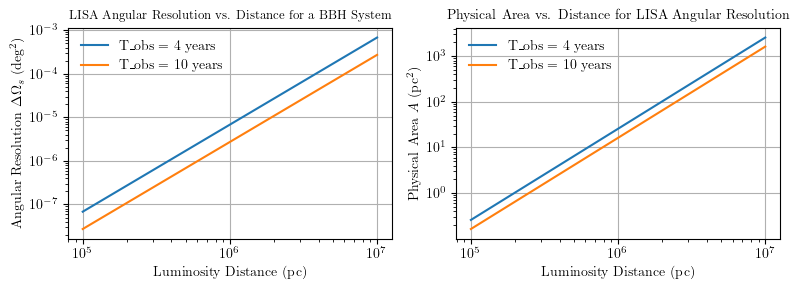

In [20]:
# Physical constants
G = constants.G          # Gravitational constant (m^3 kg^-1 s^-2)
c = constants.c          # Speed of light (m s^-1)
pc = constants.parsec    # Parsec in meters
yr = constants.year      # One year in seconds
Msun = 1.989e30          # Solar mass in kg

# Fixed parameters
f = 1e-3                 # Frequency in Hz (1 mHz)
m1 = 5e3                 # Mass of black hole 1 in solar masses
m2 = 5e3                 # Mass of black hole 2 in solar masses
e = 0                    # Eccentricity
z = 0                    # Redshift
n = 2                    # Harmonic number


def calc_SNR(T_obs, f, m1, m2, e, z, D_L):
    """Calculating SNR for the galactic (and extragalactic) sources"""

    # Define parameter values
    G = constants.G       # Gravitational constant (m^3/kg/s^2)
    Msun = 1.989e30       # Solar mass (kg)
    c = constants.c       # Speed of light (m/s)
    pc = constants.parsec # Parsec (m)
    yr = constants.year   # seconds in yr

    # Convert T_obs to years 
    T_obs_yr = T_obs / yr

    # Fix the parameters of the confusion noise fit
    if T_obs_yr <= 0.75:
        alpha = 0.133
        beta = 243.0
        kappa = 482.0
        gamma = 917.0
        fk = 2.58e-3
    elif 0.75 < T_obs_yr <= 1.5:
        alpha = 0.171
        beta = 292.0
        kappa = 1020.0
        gamma = 1680.0
        fk = 2.15e-3
    elif 1.5 < T_obs_yr <= 3.0:
        alpha = 0.165
        beta = 299.0
        kappa = 611.0
        gamma = 1340.0
        fk = 1.73e-3
    else:
        alpha = 0.138
        beta = -221.0
        kappa = 521.0
        gamma = 1680.0
        fk = 1.13e-3

    # Define the expressions for P_OMS and P_acc
    P_OMS = (1.5e-11)**2 * (1 + (2e-3 / f)**4)
    P_acc = (3e-15)**2 * (1 + (0.4e-3 / f)**2) * (1 + (f / 8e-3)**4)
    L = 2.5e9  # LISA arm length in meters
    f_star = 19.09e-3

    # Define the expression for S_c
    A = 9e-45
    S_WDB = A * f**(-7/3) * np.exp(-f**alpha + beta * f * np.sin(kappa * f)) * (1 + np.tanh(gamma * (fk - f)))
    S_ins = (10 / (3 * L**2)) * (P_OMS + (4 * P_acc) / ( (2 * np.pi * f)**4 )) * (1 + (6 / 10) * (f / f_star)**2)
    S_n = S_ins + S_WDB

    # Convert masses to kg
    m1 = m1 * Msun
    m2 = m2 * Msun
    Mtot = m1 + m2
    mu = m1 * m2 / Mtot
    M_chirp = mu**(3/5) * Mtot**(2/5)

    # Luminosity distance in meters
    D_L_m = D_L * pc

    # Calculate the strain in harmonic n
    hn = h_n(n, M_chirp, e, f, z, D_L_m)

    # Calculate the SNR
    SNR = hn * np.sqrt(T_obs) / np.sqrt(S_n)

    return SNR

# Define distance array (in parsecs)
D_L_array = np.linspace(1e5, 1e7, 100)  

# Observation times in seconds
T_obs_4yr = 4 * yr
T_obs_10yr = 10 * yr

# Initialize arrays to store SNRs and angular resolutions
SNR_4yr = []
SNR_10yr = []
Delta_Omega_4yr = []
Delta_Omega_10yr = []
Area_4yr = []
Area_10yr = []

for D_L in D_L_array:
    # Calculate SNR for T_obs = 4 years
    snr_4yr = calc_SNR(T_obs_4yr, f, m1, m2, e, z, D_L)
    SNR_4yr.append(snr_4yr)
    # Calculate angular resolution in steradians
    Delta_Omega_s_4yr = 4.8e-4 * (f / 1e-2)**(-2) * (snr_4yr / 10)**(-2)
    Delta_Omega_4yr.append(Delta_Omega_s_4yr)
    # Calculate physical area A = D_L^2 * Delta_Omega_s
    D_L_m = D_L * pc  # Convert D_L to meters
    Area_m2_4yr = D_L_m**2 * Delta_Omega_s_4yr  # Area in square meters
    Area_4yr.append(Area_m2_4yr)

    # Calculate SNR for T_obs = 10 years
    snr_10yr = calc_SNR(T_obs_10yr, f, m1, m2, e, z, D_L)
    SNR_10yr.append(snr_10yr)
    # Calculate angular resolution in steradians
    Delta_Omega_s_10yr = 4.8e-4 * (f / 1e-2)**(-2) * (snr_10yr / 10)**(-2)
    Delta_Omega_10yr.append(Delta_Omega_s_10yr)
    # Calculate physical area
    Area_m2_10yr = D_L_m**2 * Delta_Omega_s_10yr
    Area_10yr.append(Area_m2_10yr)

# Convert lists to numpy arrays for plotting
SNR_4yr = np.array(SNR_4yr)
SNR_10yr = np.array(SNR_10yr)
Delta_Omega_4yr = np.array(Delta_Omega_4yr)
Delta_Omega_10yr = np.array(Delta_Omega_10yr)
Area_4yr = np.array(Area_4yr)
Area_10yr = np.array(Area_10yr)
D_L_Gpc = D_L_array #/ 1e9  # Convert parsecs to Gpc

# Convert angular resolution to deg^2 for plotting
Delta_Omega_deg2_4yr = Delta_Omega_4yr * 3282.80635
Delta_Omega_deg2_10yr = Delta_Omega_10yr * 3282.80635

# Convert physical area from m^2 to pc^2 (since 1 pc = 3.0857e16 m)
pc_in_meters = pc
Area_pc2_4yr = Area_4yr / (pc_in_meters**2)
Area_pc2_10yr = Area_10yr / (pc_in_meters**2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Subplot 1: Angular Resolution vs Distance
axs[0].plot(D_L_Gpc, Delta_Omega_deg2_4yr, label='T_obs = 4 years')
axs[0].plot(D_L_Gpc, Delta_Omega_deg2_10yr, label='T_obs = 10 years')
axs[0].set_xlabel('Luminosity Distance (pc)')
axs[0].set_ylabel('Angular Resolution $\\Delta \\Omega_s$ (deg$^2$)')
axs[0].set_title('LISA Angular Resolution vs. Distance for a BBH System', fontsize = 9)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Physical Area vs Distance
axs[1].plot(D_L_Gpc, np.sqrt(Area_pc2_4yr / np.pi), label='T_obs = 4 years')
axs[1].plot(D_L_Gpc, np.sqrt(Area_pc2_10yr / np.pi), label='T_obs = 10 years')
axs[1].set_xlabel('Luminosity Distance (pc)')
axs[1].set_ylabel('Physical Area $A$ (pc$^2$)')
axs[1].set_title('Physical Area vs. Distance for LISA Angular Resolution', fontsize = 10)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()
